Ethereum ARIMA modelling By Joe Ganser
PART 1:
-The goal was to be able to make a time series forecast of the prices of Ethereum. 
-The metrics were the RMSE error, and also visual representation of the prediction plot vs actual values. 
-My findings that I was able to get a very good accurate prediction of the last 7 days of prices. 
-The risks & limitations were that I only had time series data, and I was only able to account for the noise and trends. Other influences on currency price were not accounted for.

Part 2:
-The variable of interest was the closing price. 
-No outlierts were removed. 
-I performed imputation of the mean in some places where NaN values were present. Also, the data had to be transformed (put into natural log form) to do ARIMA modelling

Part 3: Model selection was ARIMA.

Selection: This was selected because of the fact that the data was based on time series, which has a moving average. Also, the data had to be transformed to become "stationary" so that the trend was eliminated.

Implementation: After the trend was eliminated, the noise could be predicted and factored back into the model to give a good price prediction.

Evaluation: The evaluation was formed using the mean square error between predictions and actual values. Also, visual inspection could demontstrate high accuracy over the last 14 days of August.

Inference: We can conclude that the data follows a first order recursive expnonential trend. Images below can graphically and symbolically describe this more.

In [1]:
import pandas as pd, numpy as np
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt

#https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory
#https://www.kaggle.com/mczielinski/bitcoin-historical-data


#CRYPTOCURRENCY PRICE HISTORY

dateparse = lambda x: pd.datetime.strptime(x,'%m/%d/%Y')

ethereum_dataset = pd.read_csv('ethereum_dataset.csv',\
                              parse_dates=['Date(UTC)'],date_parser=dateparse)


ethereum_dataset = ethereum_dataset[['Date(UTC)','eth_etherprice']]
ethereum_dataset = ethereum_dataset[ethereum_dataset['eth_etherprice']>0]
ethereum_dataset.rename(columns={'Date(UTC)':'Date','eth_etherprice':'Close'},inplace=True)

ethereum_dataset.reset_index(inplace=True)
ethereum_dataset.drop('index',axis=1,inplace=True)

bits = ethereum_dataset[['Date','Close']]
bits['Date'] = pd.to_datetime(bits['Date'])
bits_indexed = bits.set_index('Date')
data = bits_indexed['Close']



def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(rotation=45)
    plt.show(block=False)
    
    
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries,regression = 'ct', autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    #print dfoutput
    return dfoutput



/Users/Research/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The data points are converted to a function that satisfies the dickey fuller test.

This function can then be used in ARIMA modelling to find the noise.


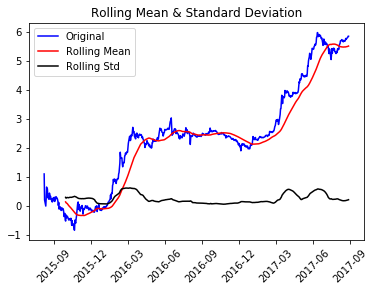

Results of Dickey-Fuller Test:


Test Statistic                  -1.355346
p-value                          0.873549
#Lags Used                       3.000000
Number of Observations Used    747.000000
Critical Value (5%)             -3.416384
Critical Value (1%)             -3.970941
Critical Value (10%)            -3.130518
dtype: float64

In [2]:
test_stationarity(np.log(data))

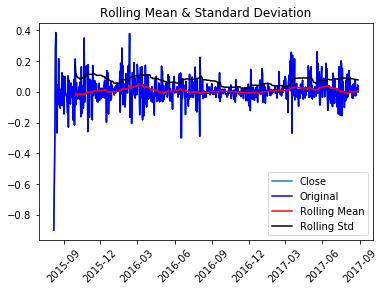

Results of Dickey-Fuller Test:


Test Statistic                 -16.545354
p-value                          0.000000
#Lags Used                       2.000000
Number of Observations Used    747.000000
Critical Value (5%)             -3.416384
Critical Value (1%)             -3.970941
Critical Value (10%)            -3.130518
dtype: float64

In [3]:
bits_log = np.log(data)
bits_log_shift = bits_log - bits_log.shift(1)
bits_log_shift.dropna(inplace=True)
plt.plot(bits_log_shift)
test_stationarity(bits_log_shift)

Using the natural logarithm (np.log(data)) of the data did NOT meet the criteria 
of the Dickey Fuller test.

So taking a step further, the shifted value of the data's logarithm 
np.log(data) - np.log(data).shift() 
was used and found to satisfy 
the dickey fuller test.

This then means the ARIMA model must use d=1 to fit the data of np.log(data)

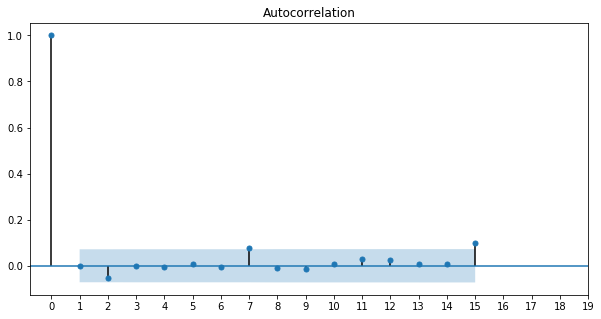

In [4]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(bits_log_shift.values, lags=15, ax=ax)
plt.xticks(np.arange(0, 20, 1))
plt.show()

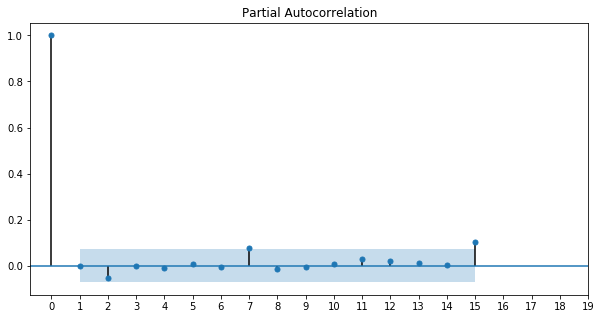

In [5]:
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(bits_log_shift.values, lags=15, ax=ax)
plt.xticks(np.arange(0, 20, 1.0))
plt.show()

The autocorrelation drops off at 1, so let q=1 in ARIMA.

The partial autocorrelation drops off at 1, so let p=1 in ARIMA.


Now the model is trained on the converted data points upto the last 7 days.

The objective is to predict the final 7 days of the time series.

In [6]:
train = bits_log[:-7]
test = bits_log[-7:]
history = [x for x in train]

train.dropna(inplace=True)
test.dropna(inplace=True)

The ARIMA model is now fitted to the logarithm of data points
![](1.png)

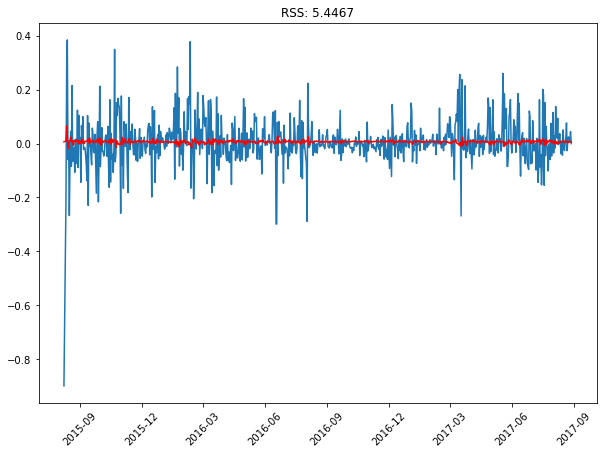

In [7]:
model = ARIMA(bits_log, order=(2, 1, 1))  
model_fit = model.fit(disp=-1)  
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(bits_log_shift)
plt.plot(model_fit.fittedvalues, color='red')
plt.xticks(rotation=45)
plt.title('RSS: %.4f'% sum((model_fit.fittedvalues-bits_log_shift)**2))

plt.show()

![](2.png)

Root mean square error: 59.1431


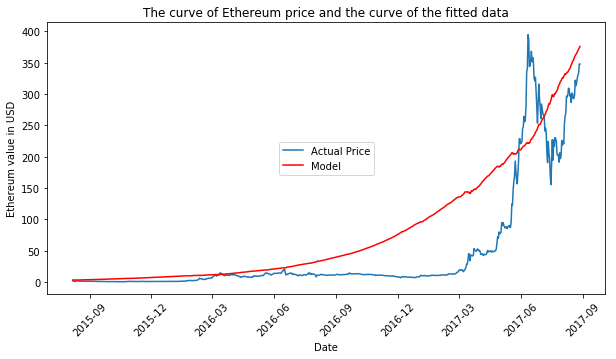

In [8]:
fittedvalues = pd.Series(model_fit.fittedvalues, copy=True)
fitcumsum = fittedvalues.cumsum()
predictions_ARIMA_log = pd.Series(bits_log.iloc[0], index=bits_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(fitcumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data,label='Actual Price')
ax.plot(predictions_ARIMA,color = 'red',label='Model')
ax.set(title='The curve of Ethereum price and the curve of the fitted data',\
         xlabel='Date', ylabel='Ethereum value in USD')
print ('Root mean square error: %.4f'% np.sqrt(sum((predictions_ARIMA-data)**2)/len(data)))
legend = ax.legend(loc='center')
plt.xticks(rotation=45)
plt.show()

In this part the predictions are made. A for loop is defined for the length of the test set. On each point in the loop, the model is redefined, adding an element to the 'history' set for which the model is formed upon. At at i = 0 for the loop,

The model is formed based on the history set (which is identical to the train set), and then a prediction is made for the next day. That prediction is appended to the predicted_values list (to be plotted) and the the first element of the test set is appeneded to the history set.

At i=1 the model is redefined so that its now based on the updated version of the history set, that now includes the first element of the test set. Then we again the model predicts the next day and appends this to the predicted_values list to be plotted. And as the loop goes on it goes through the length of the test set.

In [9]:
train = bits_log[:-7]
test = bits_log[-7:]
history = [x for x in train]

train.dropna(inplace=True)
test.dropna(inplace=True)


predicted_values = []
tested = []
for i in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    forecast = model_fit.forecast()
    yhat = float(model_fit.forecast()[0])
    predicted_values.append(yhat)
    tested_values = test[i]
    tested.append(tested_values)
    history.append(tested_values)
    print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(tested_values)))

error = mean_squared_error(test, predicted_values)

print('\n')
print('Test Mean Squared Error: %.6f' % error)

predictions_series = pd.Series(predicted_values, index = test.index)

predicted=323.626295, expected=313.370000
predicted=313.971839, expected=317.400000
predicted=319.996166, expected=325.280000
predicted=327.244436, expected=330.060000
predicted=331.774166, expected=332.860000
predicted=334.791376, expected=347.880000
predicted=350.026018, expected=347.660000


Test Mean Squared Error: 0.000432


We can use this model to predict the price of the last 7 days in the time series

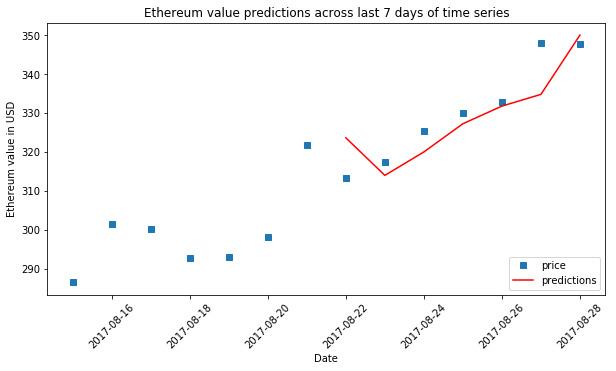

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set(title='Ethereum value predictions across last 7 days of time series', \
       xlabel='Date', ylabel='Ethereum value in USD')
ax.plot(data[-14:], 's', label='price')
ax.plot(np.exp(predictions_series), 'r', label='predictions')
legend = ax.legend(loc='lower right')
plt.xticks(rotation=45)
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  749
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 781.396
Method:                       css-mle   S.D. of innovations              0.085
Date:                Mon, 18 Sep 2017   AIC                          -1552.792
Time:                        11:55:59   BIC                          -1529.698
Sample:                             1   HQIC                         -1543.893
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0064      0.003      2.214      0.027       0.001       0.012
ar.L1.D.y      0.0574      0.687      0.083      0.933      -1.290       1.404
ar.L2.D.y     -0.0638      0.040     -1.600      0.1

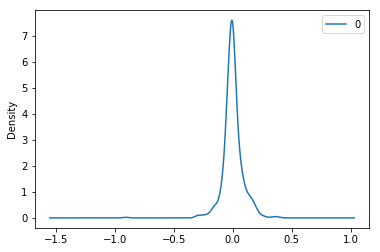

In [11]:
print model_fit.summary()
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
plt.show()

This was an import tutorial I worked with.
https://datascience.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c